# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [1]:
import os
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np



/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch_geometric

from scipy.special import softmax
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances



/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [3]:
from grace.base import GraphAttrs, Annotation
from grace.io.image_dataset import ImageGraphDataset

# from grace.simulator.simulate_graph import random_graph, random_graph_mixed_motifs
from grace.simulator.simulate_image import montage_from_image
from grace.models.feature_extractor import FeatureExtractor
from grace.models.datasets import dataset_from_subgraphs, dataset_from_whole_graph
from grace.models.optimise import optimise_graph


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load the train & test example images:

In [4]:
ROOT_DR = "/Users/kulicna/Desktop/classifier/data_fake/"
DR_TRAIN = Path(ROOT_DR + "train/padded/")
DR_INFER = Path(ROOT_DR + "infer/padded/")

DR_TRAIN.is_dir(), DR_INFER.is_dir()

(True, True)

In [5]:
image_graph_dataset_train = ImageGraphDataset(
    image_dir=DR_TRAIN,
    grace_dir=DR_TRAIN,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)


In [6]:
image_graph_dataset_infer = ImageGraphDataset(
    image_dir=DR_INFER,
    grace_dir=DR_INFER,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)


In [7]:
color_cycle = {0: "dodgerblue", 1: "darkorange", 2: "forestgreen"}
color_cycle

{0: 'dodgerblue', 1: 'darkorange', 2: 'forestgreen'}

In [8]:
for image, target in image_graph_dataset_train:
    print (f"{target['metadata']['image_filename']}: {image.shape} | Graph: nodes = {target['graph'].number_of_nodes()}, edges = {target['graph'].number_of_edges()}")

    

MRC_Synthetic_File_000: torch.Size([3948, 3948]) | Graph: nodes = 169, edges = 492
MRC_Synthetic_File_001: torch.Size([3948, 3948]) | Graph: nodes = 205, edges = 599
MRC_Synthetic_File_002: torch.Size([3948, 3948]) | Graph: nodes = 198, edges = 579
MRC_Synthetic_File_003: torch.Size([3948, 3948]) | Graph: nodes = 234, edges = 686
MRC_Synthetic_File_004: torch.Size([3948, 3948]) | Graph: nodes = 231, edges = 677
MRC_Synthetic_File_005: torch.Size([3948, 3948]) | Graph: nodes = 191, edges = 556
MRC_Synthetic_File_006: torch.Size([3948, 3948]) | Graph: nodes = 184, edges = 535
MRC_Synthetic_File_007: torch.Size([3948, 3948]) | Graph: nodes = 205, edges = 597
MRC_Synthetic_File_008: torch.Size([3948, 3948]) | Graph: nodes = 193, edges = 562
MRC_Synthetic_File_009: torch.Size([3948, 3948]) | Graph: nodes = 241, edges = 708


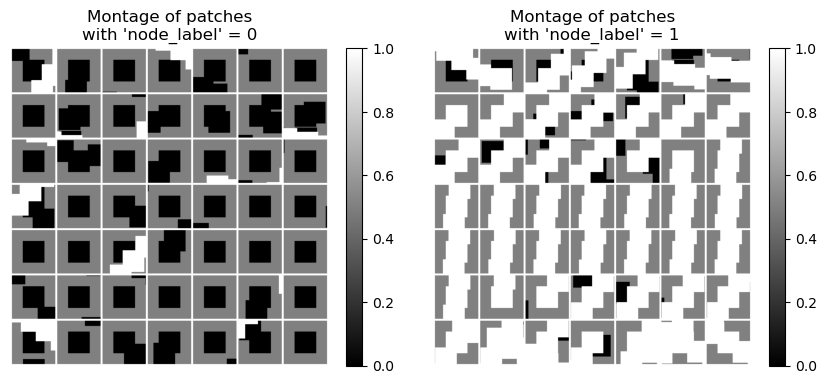

In [9]:
patch_size = (224, 224)
sample_image = image_graph_dataset_infer[0][0]
sample_graph = image_graph_dataset_infer[0][1]['graph']
montage_from_image(G=sample_graph, image=sample_image.T, crop_shape=patch_size)


[]

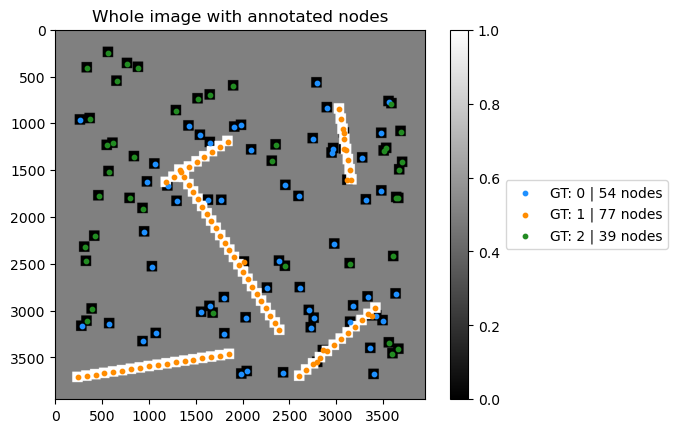

In [10]:
node_coords = [[] for _ in range(3)]

for idx, node in sample_graph.nodes.data():
    coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
    label = node[GraphAttrs.NODE_GROUND_TRUTH]
    node_coords[label].append(coords)

plt.imshow(sample_image, cmap="binary_r")
plt.colorbar()
for group_idx in range(len(node_coords)):
    group_data = np.array(node_coords[group_idx])
    plt.scatter(x=group_data[:, 0], y=group_data[:, 1], color=color_cycle[group_idx],
                s=10, label=f"GT: {group_idx} | {group_data.shape[0]} nodes")
plt.title("Whole image with annotated nodes")
plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.plot()


### Run the entire training dataset through the feature extractor:

In [11]:
def extract_TN_and_TP_node_features(image_graph_dataset, feature_extractor):

    node_patch_features = [[], []]

    for sample_image, target in tqdm(image_graph_dataset, desc="Extracting features from patches in training dataset... "):
        _, updated_graph = feature_extractor(image=sample_image, graph=target)
        for _, node in updated_graph['graph'].nodes(data=True):
            label = node[GraphAttrs.NODE_GROUND_TRUTH] if node[GraphAttrs.NODE_GROUND_TRUTH] < 2 else 0
            node_patch_features[label].append(node[GraphAttrs.NODE_FEATURES].numpy())

    node_patch_features = [np.array(item) for item in node_patch_features]
    return node_patch_features


In [12]:
feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
feature_extractor = FeatureExtractor(model=feature_extractor, bbox_size=patch_size)


In [13]:
node_patch_features_train = extract_TN_and_TP_node_features(image_graph_dataset_train, feature_extractor)
[item.shape for item in node_patch_features_train]


Extracting features from patches in training dataset... :   0%|          | 0/10 [00:00<?, ?it/s]/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
Extracting features from patches in training dataset... :  10%|█         | 

[(914, 2048), (1137, 2048)]

### Perform the TSNE:

In [14]:
node_patches = np.concatenate(node_patch_features_train)
node_embed_train = TSNE(n_components=2).fit_transform(X=node_patches)
node_embed_train.shape


(2051, 2)

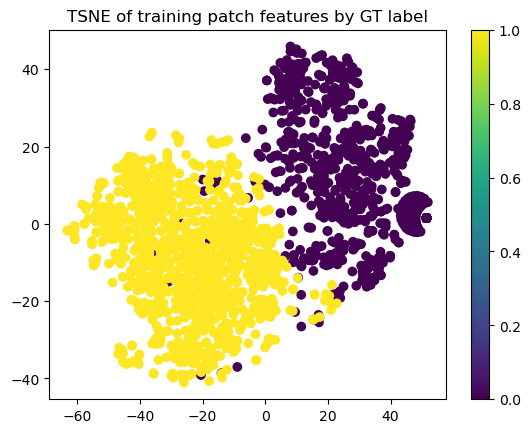

In [15]:
labels = [0] * len(node_patch_features_train[0]) + [1] * len(node_patch_features_train[1])
plt.scatter(x=node_embed_train[:, 0], y=node_embed_train[:, 1], c=labels, cmap="viridis")
plt.colorbar()
plt.title("TSNE of training patch features by GT label")
plt.show()


## Perform inference:

In [16]:
node_patch_features_infer = extract_TN_and_TP_node_features(image_graph_dataset_infer, feature_extractor)
[item.shape for item in node_patch_features_infer]


Extracting features from patches in training dataset... :   0%|          | 0/1 [00:00<?, ?it/s]/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Extracting features from patches in training dataset... : 100%|██████████| 1/1 [00:31<00:00, 31.61s/it]


[(93, 2048), (77, 2048)]

In [17]:
for infer_image, infer_target in tqdm(image_graph_dataset_infer, desc="Extracting features from patches in training dataset... "):
    print (f"{infer_target['metadata']['image_filename']}: {infer_image.shape} | Graph: nodes = {infer_target['graph'].number_of_nodes()}, edges = {infer_target['graph'].number_of_edges()}")
    _, updated_graph = feature_extractor(image=infer_image, graph=infer_target)


Extracting features from patches in training dataset... :   0%|          | 0/1 [00:00<?, ?it/s]

MRC_Synthetic_File_000: torch.Size([3948, 3948]) | Graph: nodes = 170, edges = 495


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Extracting features from patches in training dataset... : 100%|██████████| 1/1 [00:31<00:00, 31.60s/it]


### Calculate the distances:

In [18]:
distance_matrix = pairwise_distances(np.concatenate(node_patch_features_train), np.concatenate(node_patch_features_infer), metric="euclidean")
distance_matrix.shape

(2051, 170)

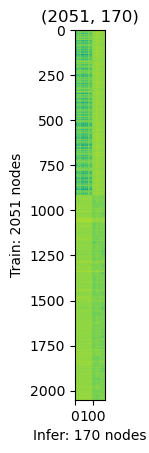

In [19]:
plt.imshow(distance_matrix)
plt.title(distance_matrix.shape)
plt.ylabel(f"Train: {distance_matrix.shape[0]} nodes")
plt.xlabel(f"Infer: {distance_matrix.shape[1]} nodes")
plt.show()

### Calculate the confusion matrix:

In [20]:
best_fit = np.argmin(distance_matrix, axis=0)
best_fit.shape


(170,)

In [21]:
conf_mat = np.zeros(shape=(2, 2))

for i in range(best_fit.shape[0]):
    row_idx = 0 if i < node_patch_features_infer[0].shape[0] else 1
    col_idx = 0 if best_fit[i] < node_patch_features_train[0].shape[0] else 1
    conf_mat[row_idx, col_idx] += 1
    

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


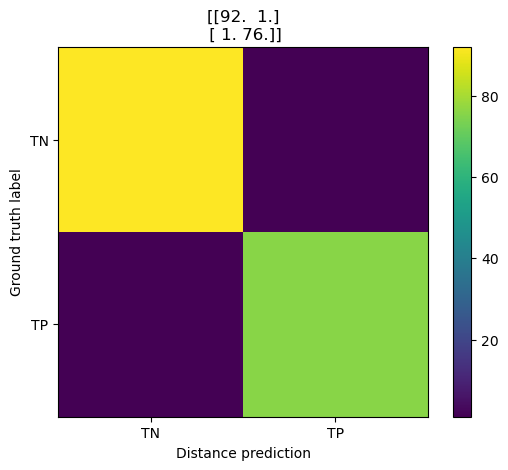

In [22]:
plt.imshow(conf_mat)
plt.title(conf_mat)

plt.ylabel(f"Ground truth label")
plt.yticks(ticks=[0, 1], labels=["TN", "TP"])
plt.xlabel(f"Distance prediction")
plt.xticks(ticks=[0, 1], labels=["TN", "TP"])

plt.colorbar()
plt.show()

# INFERENCE:

In [69]:
def get_node_and_edge_predictions(G, train_features):
    
    all_nodes = G.nodes(data=True)

    for _, node in all_nodes:
        node_features = node[GraphAttrs.NODE_FEATURES].numpy()[np.newaxis, ...]
        predictions = [pairwise_distances(class_patches, node_features) for class_patches in train_features]
        predictions = [np.mean(pd) for pd in predictions]
        # predictions = [np.min(pd) for pd in predictions]
        # predictions = np.flip(predictions)
        predictions = softmax(predictions)
        node[GraphAttrs.NODE_PREDICTION] = predictions[1].item()  # you want lower distance to be the key!
        # node[GraphAttrs.NODE_PREDICTION] = 1 - predictions[1].item()  # you want lower distance to be the key!
        
    for src, dst, edge in G.edges(data=True):
        src_node_pred = all_nodes[src][GraphAttrs.NODE_PREDICTION]
        dst_node_pred = all_nodes[dst][GraphAttrs.NODE_PREDICTION]
        # edge[GraphAttrs.EDGE_PREDICTION] = src_node_pred * dst_node_pred
        # edge[GraphAttrs.EDGE_PREDICTION] = 1 - (src_node_pred * dst_node_pred)
        # edge[GraphAttrs.EDGE_PREDICTION] = np.max([src_node_pred, dst_node_pred])
        # edge[GraphAttrs.EDGE_PREDICTION] = src_node_pred * dst_node_pred * 0.0
        # edge[GraphAttrs.EDGE_PREDICTION] = 0.5
        edge[GraphAttrs.EDGE_PREDICTION] = 0.9
    
    return G


In [70]:
G = updated_graph['graph']
G = get_node_and_edge_predictions(G=G, train_features=node_patch_features_train)


### Visualise a histogram of the predictions:

In [71]:
def visualise_histogram_of_probabilities(G: nx.Graph) -> None:

    node_preds = [node[GraphAttrs.NODE_PREDICTION] for _, node in G.nodes(data=True)]
    edge_preds = [edge[GraphAttrs.EDGE_PREDICTION] for _, _, edge in G.edges(data=True)]
    
    plt.hist(node_preds, label=f"Nodes: {len(node_preds)}")
    plt.hist(edge_preds, label=f"Edges: {len(edge_preds)}")
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Predicted softmax probability")
    plt.ylabel("Attribute count")
    plt.title("Distribution of infered image predictions")
    plt.legend()
    plt.show()


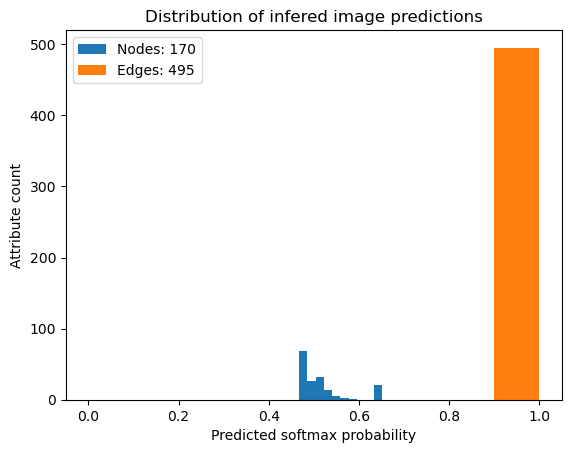

In [72]:
visualise_histogram_of_probabilities(G)


### Visualise the predicted probabilities per-node & per-edge:

In [73]:
def visualise_node_and_edge_probabilities(G: nx.Graph) -> None:

    # Just the nodes:
    all_nodes = G.nodes(data=True)
    node_attributes = [(node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y], node[GraphAttrs.NODE_PREDICTION]) for _, node in all_nodes]
    node_attributes = np.array(node_attributes)
    
    plt.scatter(x=node_attributes[:, 0], y=node_attributes[:, 1], c=node_attributes[:, 2], cmap="PiYG")
    plt.colorbar()
    plt.title("Just the nodes [probability of 'nodeness']")
    plt.show()

    # Just the edges:
    edge_attributes = [[all_nodes[src][GraphAttrs.NODE_X], all_nodes[src][GraphAttrs.NODE_Y], all_nodes[dst][GraphAttrs.NODE_X], all_nodes[dst][GraphAttrs.NODE_Y], edge[GraphAttrs.EDGE_PREDICTION]] for src, dst, edge in G.edges(data=True)] 
    edge_attributes = np.array(edge_attributes)

    for src, dst, edge in G.edges(data=True):
        edge_st = all_nodes[src][GraphAttrs.NODE_X], all_nodes[src][GraphAttrs.NODE_Y]
        edge_en = all_nodes[dst][GraphAttrs.NODE_X], all_nodes[dst][GraphAttrs.NODE_Y]
        edge_pred = edge[GraphAttrs.EDGE_PREDICTION]
        plt.plot([edge_st[0], edge_en[0]], [edge_st[1], edge_en[1]], color='k', alpha=edge_pred)
    plt.scatter(x=node_attributes[:, 0], y=node_attributes[:, 1], c=node_attributes[:, 2], s=0, cmap="binary")
    plt.colorbar()
    plt.title("Just the edges [probability of 'edgeness']")
    plt.show()

    # Both together:
    for src, dst, edge in G.edges(data=True):
        edge_st = all_nodes[src][GraphAttrs.NODE_X], all_nodes[src][GraphAttrs.NODE_Y]
        edge_en = all_nodes[dst][GraphAttrs.NODE_X], all_nodes[dst][GraphAttrs.NODE_Y]
        edge_pred = edge[GraphAttrs.EDGE_PREDICTION]
        plt.plot([edge_st[0], edge_en[0]], [edge_st[1], edge_en[1]], color='k', alpha=edge_pred)
    plt.scatter(x=node_attributes[:, 0], y=node_attributes[:, 1], c=node_attributes[:, 2], cmap="PiYG")
    plt.colorbar()
    plt.title("Both nodes & edges combined")
    plt.show()
    

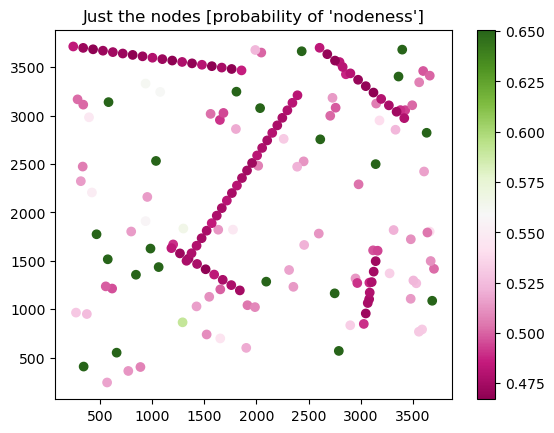

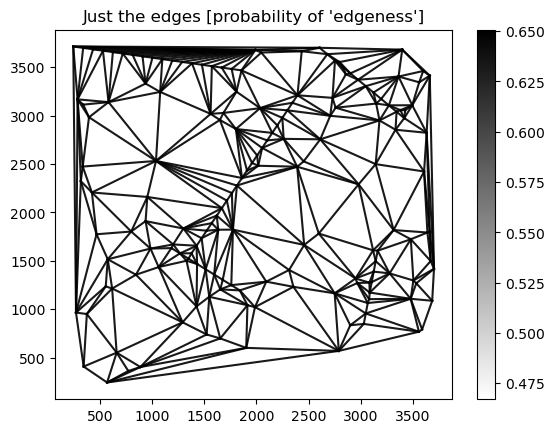

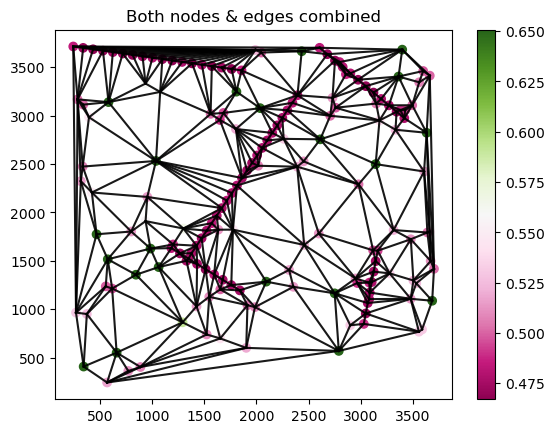

In [74]:
visualise_node_and_edge_probabilities(G)

# Optimise:

In [75]:
def visualise_optimised_graph(G: nx.Graph) -> nx.Graph:

    optimised_graph = optimise_graph(G)
    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in optimised_graph.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be part of the objects
    # plt.imshow(infer_image)
    nx.draw_networkx(optimised_graph, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(optimised_graph)
    for index, sg in enumerate(cc):
        if len(sg) <= 1:
            continue
        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = optimised_graph.subgraph(sg).copy()
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx)
    plt.title("Optimised graph")
    plt.show()
    
    return optimised_graph

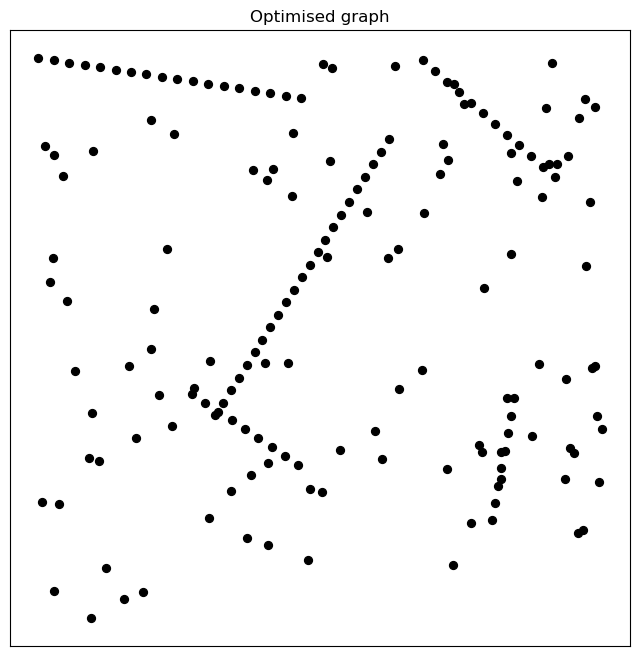

(170, 0)

In [76]:
optimised_graph = visualise_optimised_graph(G)
optimised_graph.number_of_nodes(), optimised_graph.number_of_edges()

##### Done!

NameError: name 'coords_x' is not defined

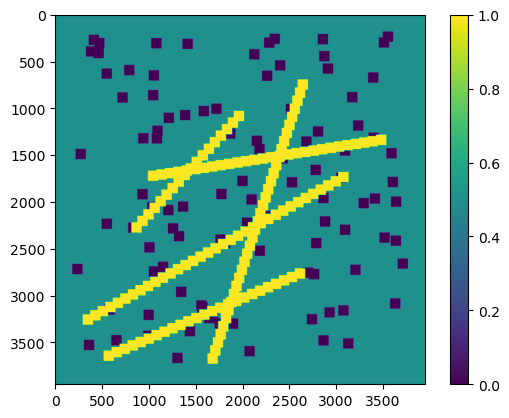

In [163]:
# plt.imshow(image, cmap="binary_r")
plt.imshow(image)
plt.colorbar()
plt.scatter(coords_x, coords_y, color='red', s=10)
plt.show()

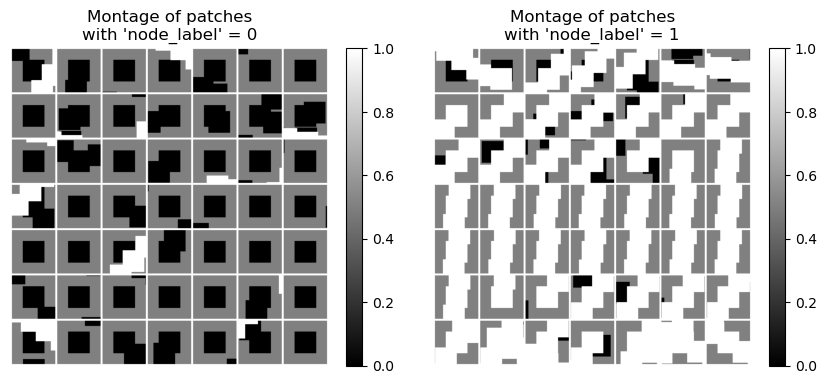

In [ ]:
montage_from_image(G=graph, image=image.T, crop_shape=(224, 224))

### Divide by labels:

In [19]:
node_coords = [[] for _ in range(3)]

for idx, node in graph.nodes.data():
    coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]

    label = node[GraphAttrs.NODE_GROUND_TRUTH]
    node_coords[label].append(coords)

[]

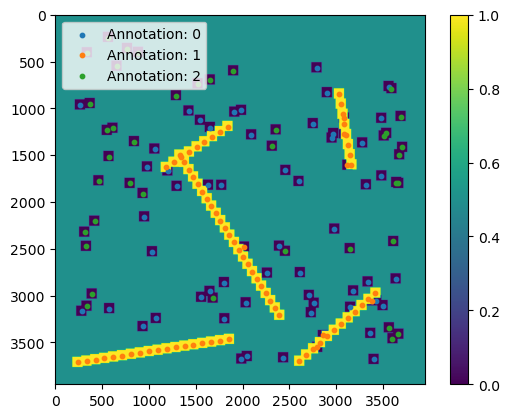

In [20]:
plt.imshow(image)
plt.colorbar()
for group_idx in range(len(node_coords)):
    group_data = node_coords[group_idx]
    group_data = np.array(group_data)
    plt.scatter(x=group_data[:, 0], y=group_data[:, 1], 
                s=10, label=f"Annotation: {group_idx}")
plt.legend(loc="upper left")
plt.plot()


In [21]:
# montage_from_image(G=graph, image=image, crop_shape=(224, 224))

### Now extract the features from each node patch:

In [22]:
# feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
# feature_extractor = FeatureExtractor(model=feature_extractor, bbox_size=(112, 112))
# feature_extractor

In [23]:
# feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
# feature_extractor = FeatureExtractor(model=feature_extractor, bbox_size=(112, 112))
# feature_extractor
# image, graph = feature_extractor(image=image, graph=graph_data)
# type(image), type(graph)

In [24]:
graph = graph_data

### Each node now has the feature vector appended to it:

In [25]:
graph = graph['graph']
single_node = graph.nodes()[0]
single_node, single_node[GraphAttrs.NODE_FEATURES].shape

({<GraphAttrs.NODE_X: 'x'>: 1652.398193359375,
  <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0., 0., 0.,  ..., 0., 0., 0.])},
 torch.Size([2048]))

### Can I cluster the patches by their features?

In [26]:
node_features = np.array([node[GraphAttrs.NODE_FEATURES].numpy() for _, node in graph.nodes(data=True)])
node_features.shape
node_GT_labels = np.array([node[GraphAttrs.NODE_GROUND_TRUTH] for _, node in graph.nodes(data=True)])
node_GT_labels.shape


(170, 2048)

In [27]:
# TODO: TSNE

tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(X=node_features)
embedding.shape


(170, 2)

In [28]:
node_GT_labels = np.array([node[GraphAttrs.NODE_GROUND_TRUTH] for _, node in graph.nodes(data=True)])
node_GT_labels.shape

(170,)

0 [-577.45844 -146.60721 -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
  630.107   -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117  -520.6117  -520.6117  -520.6117
 -520.6117  -520.6117  -520.6117   630.107   -520.6117  -520.6117 ] [824.2358    823.438     -23.65925   -23.65925   -23.65925   -23.65925
 -23.65925   -23.65925   -23.65925   -23.65925   -23.65925   -23.65925
 -23.65925   -23.65925   -23.65925   -23.65925   -23.65925   -23.65925
 -23.65925   -23.65925   -23.65925   -23.65925   -23.65925   -23.65925
 -23.65925   -23.65925   -23.65925   -23.65925   -23.65925   -23.65925
   6.5899105 -23.65925   -23.65925   -23.65925 

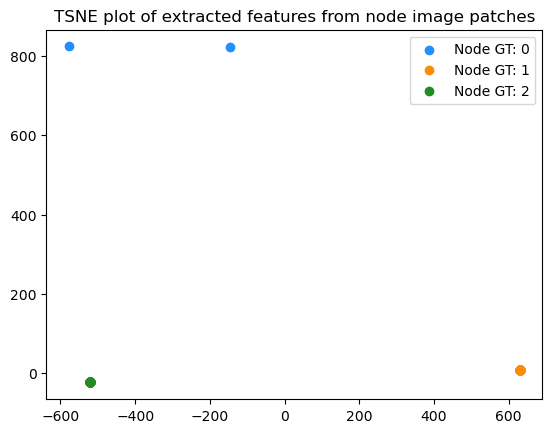

In [43]:

for key in colors.keys():
    optimised_graph, y = np.transpose([embedding[i] for i in range(node_GT_labels.shape[0]) if node_GT_labels[i] == key])
    print (key, optimised_graph, y)
    plt.scatter(x=optimised_graph, y=y, c=colors[key], label=f"Node GT: {key}")

plt.title("TSNE plot of extracted features from node image patches")
plt.legend()
plt.show()

### Use average distance to other TSNE points as the prediction:

In [30]:
node_GT = [0 for _ in range(3)]

for _, node in graph.nodes.data():
    node_GT[node[GraphAttrs.NODE_GROUND_TRUTH]] += 1

node_GT


[54, 77, 39]

In [31]:
edge_GT = [0 for _ in range(3)]

for st, en, edge in graph.edges.data():
    edge_GT[edge[GraphAttrs.EDGE_GROUND_TRUTH]] += 1

edge_GT

[190, 93, 212]

## Now run inference:

### Load the pre-trained models for node & edge classification:

In [32]:
classifier_model = torch.load("/Users/kulicna/Desktop/classifier/runs/2023-06-29_11-42-11/classifier.pt")
classifier_model

GCN(
  (node_classifier): Linear(in_features=2048, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=4096, out_features=2, bias=True)
)

In [35]:
graph = get_node_predictions(graph, classifier_model)
graph = get_edge_predictions(graph, classifier_model)
graph


### Plot the predictions of the model:

In [36]:
nodes_pred_by_group = [[single_node[GraphAttrs.NODE_PREDICTION] for _, single_node in graph.nodes.data() if single_node[GraphAttrs.NODE_GROUND_TRUTH] == anno] for anno in range(3)]
edges_pred_by_group = [[single_edge[GraphAttrs.EDGE_PREDICTION] for _, _, single_edge in graph.edges.data() if single_edge[GraphAttrs.EDGE_GROUND_TRUTH] == anno] for anno in range(3)]
[len(grp) for grp in nodes_pred_by_group], [len(grp) for grp in edges_pred_by_group]


([54, 77, 39], [190, 93, 212])

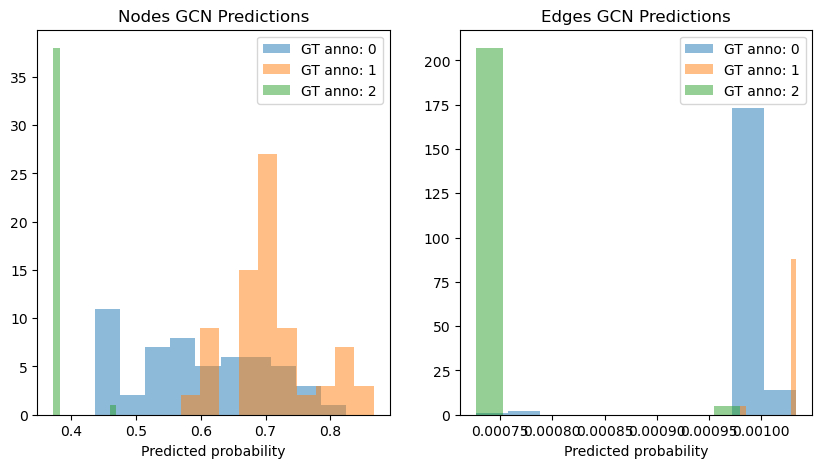

In [37]:
plt.figure(figsize=(10, 5))

for g, (graph_attribute, attribute_name) in enumerate(zip([nodes_pred_by_group, edges_pred_by_group], ["Nodes", "Edges"])):
    for anno, group in enumerate(graph_attribute):
        plt.subplot(1, 2, g+1)
        plt.hist(group, label=f"GT anno: {anno}", alpha=0.5)
        plt.title(f"{attribute_name} GCN Predictions")
        plt.xlabel("Predicted probability")
        plt.legend()
        
plt.show()
plt.close()

# Optimise a real graph:

In [38]:
optimised_graph = optimise_graph(graph)

In [39]:
optimised_graph.number_of_nodes(), optimised_graph.number_of_edges()

(170, 0)

In [40]:
for _, node in optimised_graph.nodes(data=True):
    print (node)
    break

for src, tgt, edge in optimised_graph.edges(data=True):
    print (src, tgt, edge)
    break

{<GraphAttrs.NODE_X: 'x'>: 1652.398193359375, <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0., 0., 0.,  ..., 0., 0., 0.]), <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 0.7001902461051941}


### Visualise the graph & individual objects:

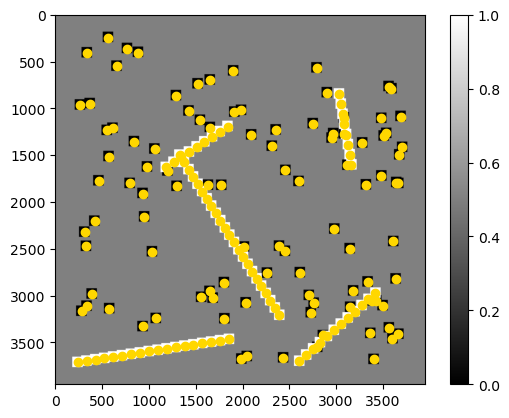

In [41]:
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

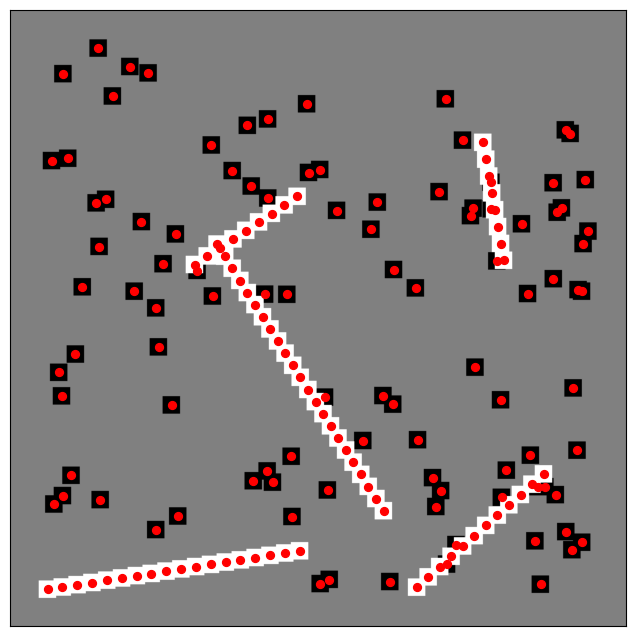

In [42]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in optimised_graph.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
plt.imshow(image, cmap="binary_r")
nx.draw_networkx(optimised_graph, ax=ax, pos=pos, with_labels=False, node_color="r", node_size=32)
plt.show()


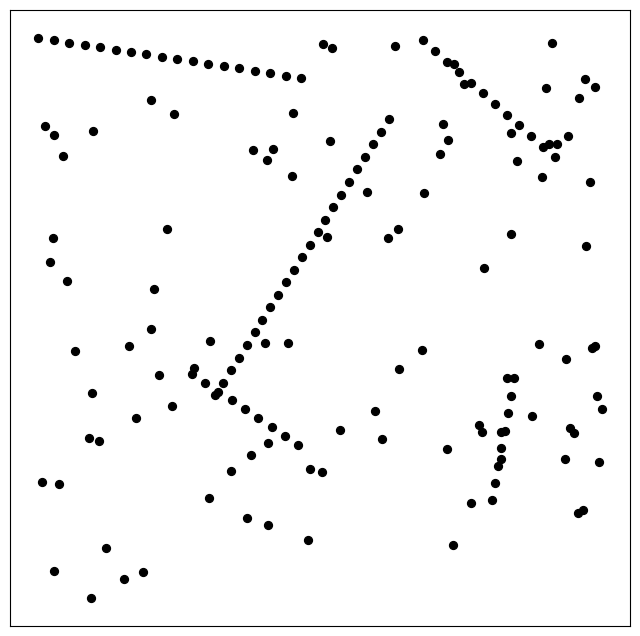

In [64]:
# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in optimised_graph.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(optimised_graph, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(optimised_graph)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = optimised_graph.subgraph(sg).copy()
    plt.imshow(image, cmap="binary_r")
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Done!